In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

#### Kmean on iris DS

[[5.6 3. ]
 [6.3 2.5]
 [5.4 3.4]]


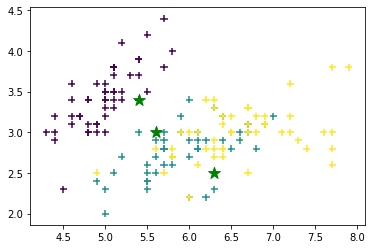

In [82]:
iris = datasets.load_iris()
X = iris.data[:, :2] 
y = iris.target

xmin1 = X[0].min()
xmin2 = X[1].min()
#print(xmin1,xmin2)

xmax1 = X[0].max()
xmax2 = X[1].max()
#print(xmax1,xmax2)

#xmean1 = X[0].mean()
#xmean2 = X[1].mean()
#print('mean',xmean1,xmean2)

#xstd1 = X[0].std()
#xstd2 = X[1].std()
#print('std',xstd1,xstd2)

#x_1 = np.random.uniform(low=xmin1, high=xmax1,size=3)
#x_2 = np.random.uniform(low=xmin2, high=xmax2,size=3)
df = pd.DataFrame(X)
centers = df.sample(3,random_state=50)
# print('sample')
# print(centers)
# print('************************')
# print(centers.iloc[0][0],centers.iloc[0][1])


#np.random.randint(low=1, high=100, size=4)
#np.random.randint(low=1, high=100, size=4)

k = 3

#centroids = np.array([[xmin1,xmin2], [xmean1,xmean2] ,[xmax1,xmax2]]) 
centroids = np.array([[centers.iloc[0][0],centers.iloc[0][1]], [centers.iloc[1][0],centers.iloc[1][1]] ,[centers.iloc[2][0],centers.iloc[2][1]]]) 
print(centroids)

plt.scatter(X[:,0], X[:,1],marker='+',c=y, s=50)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='g', s=150)




counter 0 delta_inertia 1


'clusters argmin='

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0], dtype=int64)

current_inertia 42.6944238417099
counter 1 delta_inertia 41.6944238417099


'clusters argmin='

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0], dtype=int64)

current_inertia 42.6944238417099


array([[5.65348837, 2.77906977],
       [6.68275862, 2.93103448],
       [5.01632653, 3.45102041]])

final delta_inertia 0.0 counter 2


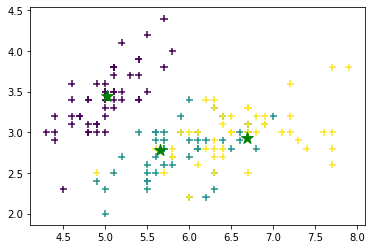

In [89]:
centroids_old = np.zeros(centroids.shape) # to store old centers
#display('centroids_old',centroids_old)
centroids_new = centroids.copy() # Store new centers
#display('centroids_new',centroids_new)

n = X.shape[0]
clusters = np.zeros(n)
distances = np.zeros((n,k))
inertia = np.zeros((k,1))
#display('clusters',clusters)
#display('distances',distances)

#print(centroids_new - centroids_old)
#print(((centroids_new - centroids_old)**2))
#print(((centroids_new - centroids_old)**2).sum(axis=1))

tolerance = 0.0001
prev_inertia, current_inertia = 0,1 

delta_inertia = current_inertia - prev_inertia #np.sqrt(((centroids_new - centroids_old)**2).sum(axis=1)) 
#display('error',error)
counter = 0
while delta_inertia > tolerance:
    print('counter', counter,'delta_inertia',delta_inertia)
    #display('X',X)
    for i in range(k):
    #         print(data - centroids[i])
    #         print(((data - centroids[i])**2))
    #         print(((data - centroids[i])**2).sum(axis=1))
    #         print(np.sqrt(((data - centroids[i])**2).sum(axis=1)))
        distances[:,i] = np.sqrt(((X - centroids[i])**2).sum(axis=1))
        #print('distances k=',i,distances[:,i])

    clusters = np.argmin(distances, axis = 1)
    display('clusters argmin=',clusters)

    centroids_old = centroids_new.copy()

    for i in range(k):
#         print(X[clusters == 1])
#         print(np.mean(X[clusters == i], axis=0))
        centroids_new[i] = np.mean(X[clusters == i], axis=0)
   
        
    for i in range(k):
        
        idx = np.where(clusters==i)
        #print('idx',idx)
        inertia[i] = np.sum(((X[idx] - centroids_new[i])**2).sum(axis=1))
        #print('inertia',inertia)

    prev_inertia = current_inertia
    current_inertia = inertia.sum()
    delta_inertia = current_inertia - prev_inertia
    counter += 1
    print('current_inertia',current_inertia)

display(centroids_new)
print('final delta_inertia',delta_inertia,'counter',counter)

plt.scatter(X[:,0], X[:,1],marker='+',c=y, s=50)
plt.scatter(centroids_new[:,0], centroids_new[:,1], marker='*', c='g', s=150)

#### Kmeans sample page 397

In [ ]:
k = 3

centroids = np.array([[0,0],[16,0],[16,6]],dtype=float)
data = np.array([[0,0],[8,0],[8,6],[16,0],[0,6],[16,6],[5,5]])


plt.scatter(data[:,0], data[:,1],marker='+', s=50)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='g', s=150)

    

In [ ]:
#run k = 1

centroids_old = np.zeros(centroids.shape) # to store old centers
display('centroids_old',centroids_old)
centroids_new = centroids.copy() # Store new centers
display('centroids_new',centroids_new)

n = data.shape[0]
clusters = np.zeros(n)
distances = np.zeros((n,k))
inertia = np.zeros((k,1))
#display('clusters',clusters)
#display('distances',distances)

#print(centroids_new - centroids_old)
#print(((centroids_new - centroids_old)**2))
#print(((centroids_new - centroids_old)**2).sum(axis=1))

tolerance = 0.0001
prev_inertia, current_inertia = 0,1 

delta_inertia = current_inertia - prev_inertia #np.sqrt(((centroids_new - centroids_old)**2).sum(axis=1)) 
#display('error',error)

while delta_inertia > tolerance:

    display('data',data)
    for i in range(k):
    #         print(data - centroids[i])
    #         print(((data - centroids[i])**2))
    #         print(((data - centroids[i])**2).sum(axis=1))
    #         print(np.sqrt(((data - centroids[i])**2).sum(axis=1)))
        distances[:,i] = np.sqrt(((data - centroids[i])**2).sum(axis=1))
        print('distances k=',i,distances[:,i])

    clusters = np.argmin(distances, axis = 1)
    display('clusters argmin=',clusters)

    centroids_old = centroids_new.copy()

    for i in range(k):
        print(np.mean(data[clusters == i], axis=0))
        centroids_new[i] = np.mean(data[clusters == i], axis=0)

    display(centroids_new)
    error -= 1 
    
    for i in range(k):
        
        idx = np.where(clusters==i)
        print('idx',idx)
        inertia[i] = np.sum(((data[idx] - centroids_new[i])**2).sum(axis=1))
        print('inertia',inertia)

    prev_inertia = current_inertia
    current_inertia = inertia.sum()
    delta_inertia = current_inertia - prev_inertia
    print('current_inertia',current_inertia)

print('final delta_inertia',delta_inertia)

plt.scatter(data[:,0], data[:,1],marker='+', s=50)
plt.scatter(centroids_new[:,0], centroids_new[:,1], marker='*', c='g', s=150)